In [1]:
%load_ext autoreload
%autoreload 2

In [86]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import cv2
import os
import time
from IPython.display import clear_output
from sklearn.utils import shuffle
from sklearn import metrics as sk_metrics
from sklearn.model_selection import RandomizedSearchCV
import pickle as pkl
import scipy.ndimage as ndimage

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost

from dataset import *
from descriptor import *
from SlidingWindow import *
from BagOfWords import *
from detection import *

In [89]:
# Load classifiers
classifiers = load_classifiers('waldo')
cascade_classifier = load_haar_classifier(detection_class='waldo')

In [26]:
# Load BOVW 
bovw = load_bovw('waldo')

In [68]:
# Load image to perform object detection on
curr_wd = os.getcwd()
test_number = '008.jpg'
test_path = os.path.join(curr_wd, 'datasets/', 'JPEGImages/', test_number)

# Load ground truth annotations
provided_annot_path = os.path.join(curr_wd, 'cache_anno/', 'classification', 'provided_annots.pkl')
with open(provided_annot_path, 'rb') as f:
    provided_annots = pickle.load(f)

In [69]:
ground_truth = [0] * 4
for box in provided_annots[test_number]:
    coord, label = box
    if label[0] == 'waldo':
        ground_truth = coord

test_image = plt.imread(test_path)
# test_image = cv2.GaussianBlur(test_image, (3, 3), cv2.BORDER_DEFAULT) # Perform gaussian smoothing

In [61]:
# Perform detection
detections = detect(test_image, bovw, classifiers, window_scale=5, desc_type='sift')
print('Number of Bounding Boxes: ', len(detections))

Current Window Size:  310 219
Current step size:  109
Current Window Size:  620 438
Current step size:  218
Current Window Size:  1240 876
Current step size:  872
Number of Bounding Boxes:  48


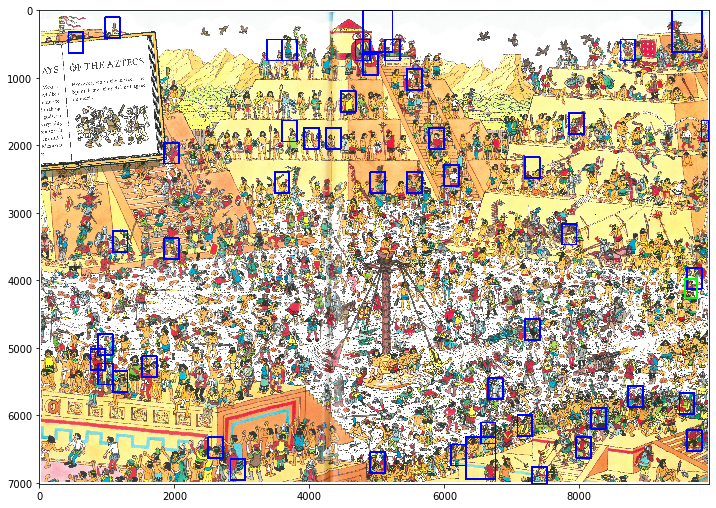

In [62]:
# Visualise detections
plt.rcParams['figure.figsize'] = (12.0, 12.0)
clone = test_image.copy()
for (x1, y1, x2, y2, score) in detections:
    cv2.rectangle(clone, (x1, y1), (x2, y2), (0, 0, 255), thickness=25)
cv2.rectangle(clone, (ground_truth[0], ground_truth[1]), (ground_truth[2], ground_truth[3]), (0, 255, 0), thickness=25)
plt.imshow(clone)

### Harr Cascade Classifier

Attempting to filter out false positives by using a harr cascade classifier trained on Waldo positives and negatives on detections

#### Using Only Haar Cascade Classifier

Visualise the results using only face detection using the trained haar cascade classifier. The result is very noisy as it detects for facial features.

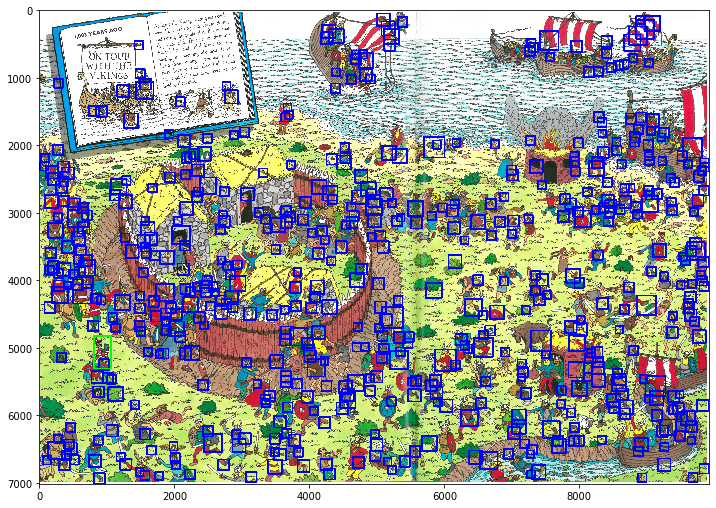

In [91]:
# Solely haar features detection for facial features
rectangles = cascade_classifier.detectMultiScale(test_image, scaleFactor=1.05, minNeighbors=20, minSize=(100, 100), maxSize=(400, 400))
clone = test_image.copy()
for (i, (x1, y1, w, h)) in enumerate(rectangles):
    cv2.rectangle(clone, (x1, y1), (x1 + w, y1 + h), (0, 0, 255), thickness=25)
cv2.rectangle(clone, (ground_truth[0], ground_truth[1]), (ground_truth[2], ground_truth[3]), (0, 255, 0), thickness=25)
plt.imshow(clone)

#### Perform Haar filtering on Sliding Window detections

Now we first use our sliding window detection as per before to obtain our detection bounding boxes, then score each detection with our haar cascade classifier to see if it contains the face of Waldo

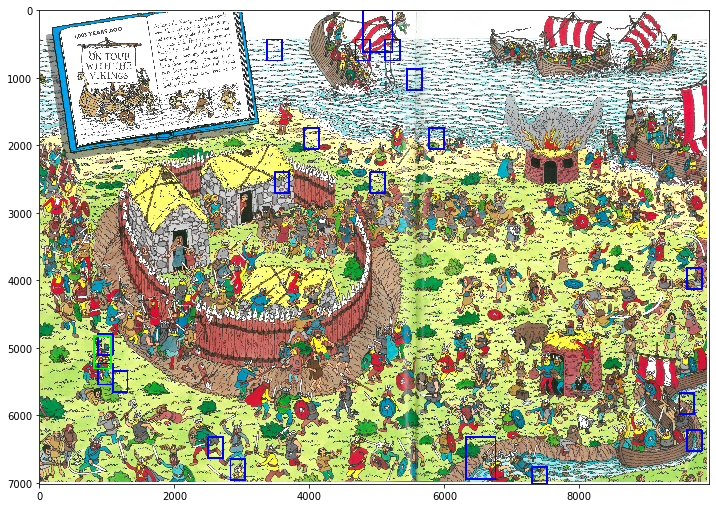

In [92]:
# Perform haar cascade filtering on the sliding window detection bounding boxes
final_detections = haar_filtering(test_image, detections, cascade_classifier)
plt.rcParams['figure.figsize'] = (12.0, 12.0)
clone = test_image.copy()
for (x1, y1, x2, y2, score) in final_detections:
    cv2.rectangle(clone, (x1, y1), (x2, y2), (0, 0, 255), thickness=25)
cv2.rectangle(clone, (ground_truth[0], ground_truth[1]), (ground_truth[2], ground_truth[3]), (0, 255, 0), thickness=25)
plt.imshow(clone)

#### Perform Classification scoring on Haar Cascade Detection

We do the reverse: we first obtain haar bounding boxes from the image as before which retrieves many noisy detections. Then, we filter out these detections using our trained classifiers.

NOTE: The bounding box format for `detectMultiScale` is `(x, y, w, h)` while the format for `detect` in `BagOfWords.py` is `(x1, y1, x2, y2)`.

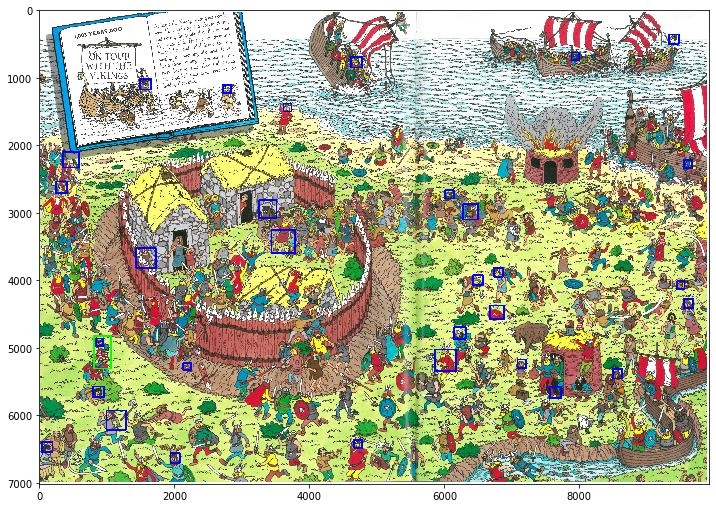

In [96]:
# Perform scoring on haar detections using our trained classifiers
haar_boxes = haar_detection(test_image, cascade_classifier, classifiers, bovw)
haar_boxes = non_max_suppression(haar_boxes, threshold=0.1, score_threshold=0.6)
plt.rcParams['figure.figsize'] = (12.0, 12.0)
clone = test_image.copy()
for (x1, y1, x2, y2, score) in haar_boxes:
    cv2.rectangle(clone, (x1, y1), (x2, y2), (0, 0, 255), thickness=25)
cv2.rectangle(clone, (ground_truth[0], ground_truth[1]), (ground_truth[2], ground_truth[3]), (0, 255, 0), thickness=25)
plt.imshow(clone)